In [1]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [2]:
import sys 
from deepscore import deepscore
from deepscore import marker_analysis

2023-04-14 12:29:30.276158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('15', '10'), color_map='gist_earth')

In [4]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',

'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#000000'}

In [5]:
def assign_lib_from_index(adata, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in adata.obs.index.tolist()]
    adata.obs['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return adata
def assign_lib_from_index_df(df, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in df.index.tolist()]
    df['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return df

In [6]:
def comparison_heatmap(adata, key1, key2, label_1=None, label_2=None):
    if label_1==None:
        label_1=key1
    if label_2==None:
        label_2=key2
    expected_df = adata.obs[[key1,key2]].groupby(by=[key2,key1]).size().reset_index(name = 'count')
    counts = np.array(expected_df['count'].tolist())
    df = pd.DataFrame(counts.reshape(((len(adata.obs[key2].cat.categories),len(adata.obs[key1].cat.categories)))), index = expected_df[key2].unique(), columns = expected_df[key1].unique())
    s = sns.heatmap(df/np.sum(df,axis = 0), cbar_kws={'label': '% cell shared between annotations'})
    s.set_ylabel(label_2, fontsize=12)
    s.set_xlabel(label_1, fontsize = 12)
    return df

In [ ]:
adata = sc.read(f'objects/merged_1stQC_Harmonized.h5ad')

In [ ]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 75318 × 35103
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Deepscore_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmonized', 'X_umap', 'X_umap_raw'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# GENERATE DOUBLETS METADATA

## Doublets finder

In [ ]:
df_list = []
for i in range(12):
    path=f'objects/split_{i+1}.rds'
    get_ipython().run_cell_magic('R', '-i path', 'a <- readRDS(path)')
    get_ipython().run_cell_magic('R', '-o a', "a <- as.SingleCellExperiment(x=a, assay = 'RNA')")
    df_list.append(a.obs[['sample','DoubletValue','DoubletClassification']])

In [ ]:
metadata = pd.concat(df_list, axis =0)
metadata.to_csv('objects/Merged_DoubletsFinder_metadata.csv')

In [ ]:
sample_list = adata.obs['sample'].unique()

In [ ]:
pd.read_csv('objects/Merged_DoubletsFinder_metadata.csv')['DoubletClassification'].value_counts()

Singlet    70499
Doublet     4819
Name: DoubletClassification, dtype: int64

## Doublet detection

In [ ]:
df_list = []
for i in sample_list:
    a = sc.read(f'objects/doubletdetection_{i}.h5ad')
    df_list.append(a.obs[['sample','doublets','doublets_score']])

In [ ]:
metadata = pd.concat(df_list, axis =0)

In [ ]:
aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv',)
aggr['subfix'] = aggr.index
aggr.index = aggr['library_id']
aggr

library_id                                     atac_fragments  \
library_id                                                                 
lib_09         lib_09  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_10         lib_10  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_15         lib_15  /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_23         lib_23  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_29         lib_29  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_34         lib_34  /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_36         lib_36  /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_kidney_03...   
lib_38         lib_38  /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_51         lib_51  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_54         lib_54  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_55         lib_55  /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_56         lib_56  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_57         lib_57  /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   

                                          per_barcode_metrics  \
library_id                                                      
lib_09      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_10      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_15      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_23      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_29      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_34      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_36      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_kidney_03...   
lib_38      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_51      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_54      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_55      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...   
lib_56      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   
lib_57      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...   

                                            gex_molecule_info  subfix  
library_id                                                             
lib_09      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       0  
lib_10      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       1  
lib_15      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...       2  
lib_23      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       3  
lib_29      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       4  
lib_34      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...       5  
lib_36      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_kidney_03...       6  
lib_38      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...       7  
lib_51      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       8  
lib_54      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...       9  
lib_55      /ijc/LABS/MEREU/RAW/CZI/MULTIOME/CZI_06-07/CZI...      10  
lib_56      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...      11  
lib_57      /mnt/beegfs/macera/CZI/MULTI/Cellrange_COUNT/l...      12

In [ ]:
metadata.iloc[0]['sample']

'lib_38'

In [ ]:
index = []
for i in range(metadata.shape[0]):
    index.append(metadata.index[i].split('-')[0]+'-'+str(int(aggr.loc[metadata.iloc[i]['sample'],'subfix'])+1))

In [ ]:
metadata['old_barcode'] = metadata.index

In [ ]:
metadata.index = index

In [ ]:
metadata.to_csv('objects/Merged_DoubletDetection_metadata.csv')

## ADD METADTA TO analysed objects

In [9]:
metadata_dd = pd.read_csv('objects/Merged_DoubletDetection_metadata.csv', index_col=0)
metadata_df = pd.read_csv('objects/Merged_DoubletsFinder_metadata.csv', index_col=0)

In [10]:
metadata_dd.head(5)

sample  doublets  doublets_score         old_barcode
AAACAGCCAACTGGCT-8  lib_38       0.0    7.541783e-17  AAACAGCCAACTGGCT-1
AAACAGCCACATAACT-8  lib_38       0.0    8.209650e-02  AAACAGCCACATAACT-1
AAACAGCCACTGACTA-8  lib_38       0.0    5.214727e-04  AAACAGCCACTGACTA-1
AAACAGCCAGGCCATT-8  lib_38       0.0    3.033204e-02  AAACAGCCAGGCCATT-1
AAACAGCCAGGCCTTG-8  lib_38       0.0    1.410786e-05  AAACAGCCAGGCCTTG-1

In [11]:
metadata_df.head(5)

sample  DoubletValue DoubletClassification
AAACAGCCAACTGGCT-8  lib_38      0.330483               Singlet
AAACAGCCACATAACT-8  lib_38      0.350031               Singlet
AAACAGCCACTGACTA-8  lib_38      0.161271               Singlet
AAACAGCCAGGCCATT-8  lib_38      0.323152               Singlet
AAACAGCCAGGCCTTG-8  lib_38      0.340867               Singlet

In [33]:
metadata_df['doublets'] = 0
metadata_df.loc[metadata_df.index[metadata_df['DoubletClassification'].isin(['Doublet'])],'doublets'] = 1

In [18]:
adata

AnnData object with n_obs × n_vars = 75318 × 35103
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore', 'DoubletsFinder_doublets', 'DoubletsFinder_doublets_score', 'DoubletsDetection_doublets', 'DoubletsDetection_doublets_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Deepscore_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'DoubletsFinder_doublets_colors', 'DoubletsDetection_doublets_colors'
    obsm: 'X_pca', 'X_pca_harmonized', 'X_umap', 'X_umap_raw'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [24]:
metadata_df = metadata_df[metadata_df.index.isin(adata.obs.index)]
metadata_dd = metadata_dd[metadata_dd.index.isin(adata.obs.index)]

In [21]:
metadata_df

sample  DoubletValue DoubletClassification  doublets
AAACAGCCAACTGGCT-8   lib_38      0.330483               Singlet         0
AAACAGCCACATAACT-8   lib_38      0.350031               Singlet         0
AAACAGCCACTGACTA-8   lib_38      0.161271               Singlet         0
AAACAGCCAGGCCATT-8   lib_38      0.323152               Singlet         0
AAACAGCCAGGCCTTG-8   lib_38      0.340867               Singlet         0
...                     ...           ...                   ...       ...
TTTGCATTCACGCATG-12  lib_56      0.068966               Singlet         0
TTTGCATTCATGCTCC-12  lib_56      0.068966               Singlet         0
TTTGCGGAGAATCTCA-12  lib_56      0.103448               Singlet         0
TTTGGTAAGGTATTGC-12  lib_56      0.068966               Singlet         0
TTTGTCCCATCGTTCT-12  lib_56      0.206897               Singlet         0

[75318 rows x 4 columns]

In [34]:
adata.obs['DoubletsFinder_doublets'] = metadata_df['doublets'].astype(bool)
adata.obs['DoubletsFinder_doublets_score'] = metadata_df['DoubletValue'].astype(float)
adata.obs['DoubletsDetection_doublets'] = metadata_dd['doublets'].astype(bool)
adata.obs['DoubletsDetection_doublets_score'] = metadata_dd['doublets_score'].astype(float)

In [35]:
adata.obs['DoubletsFinder_doublets'] = adata.obs['DoubletsFinder_doublets'].astype(str).astype('category')
adata.obs['DoubletsDetection_doublets'] = adata.obs['DoubletsDetection_doublets'].astype(str).astype('category')

In [12]:
for i in list(adata.obsm.keys()):
    adata.obsm[i+'_1stQC'] = adata.obsm[i]

In [15]:
adata.obs['Deepscore_markers'] = sc.read('objects/Deepscore_markers.h5ad').obs['Deepscore_external'].copy()
adata.obs['Deepscore_HVG'] = sc.read('objects/Deepscore.h5ad').obs['Deepscore'].copy()

In [16]:
scANVI = sc.read('objects/scANVI_label_transfer_ext_ref_DS_markers.h5ad')

In [17]:
scANVI.obs.index = [i[:-4] for i in scANVI.obs.index]

In [18]:
adata.obs['C_scANVI'] = scANVI[adata.obs.index].obs['C_scANVI'].copy()
del scANVI

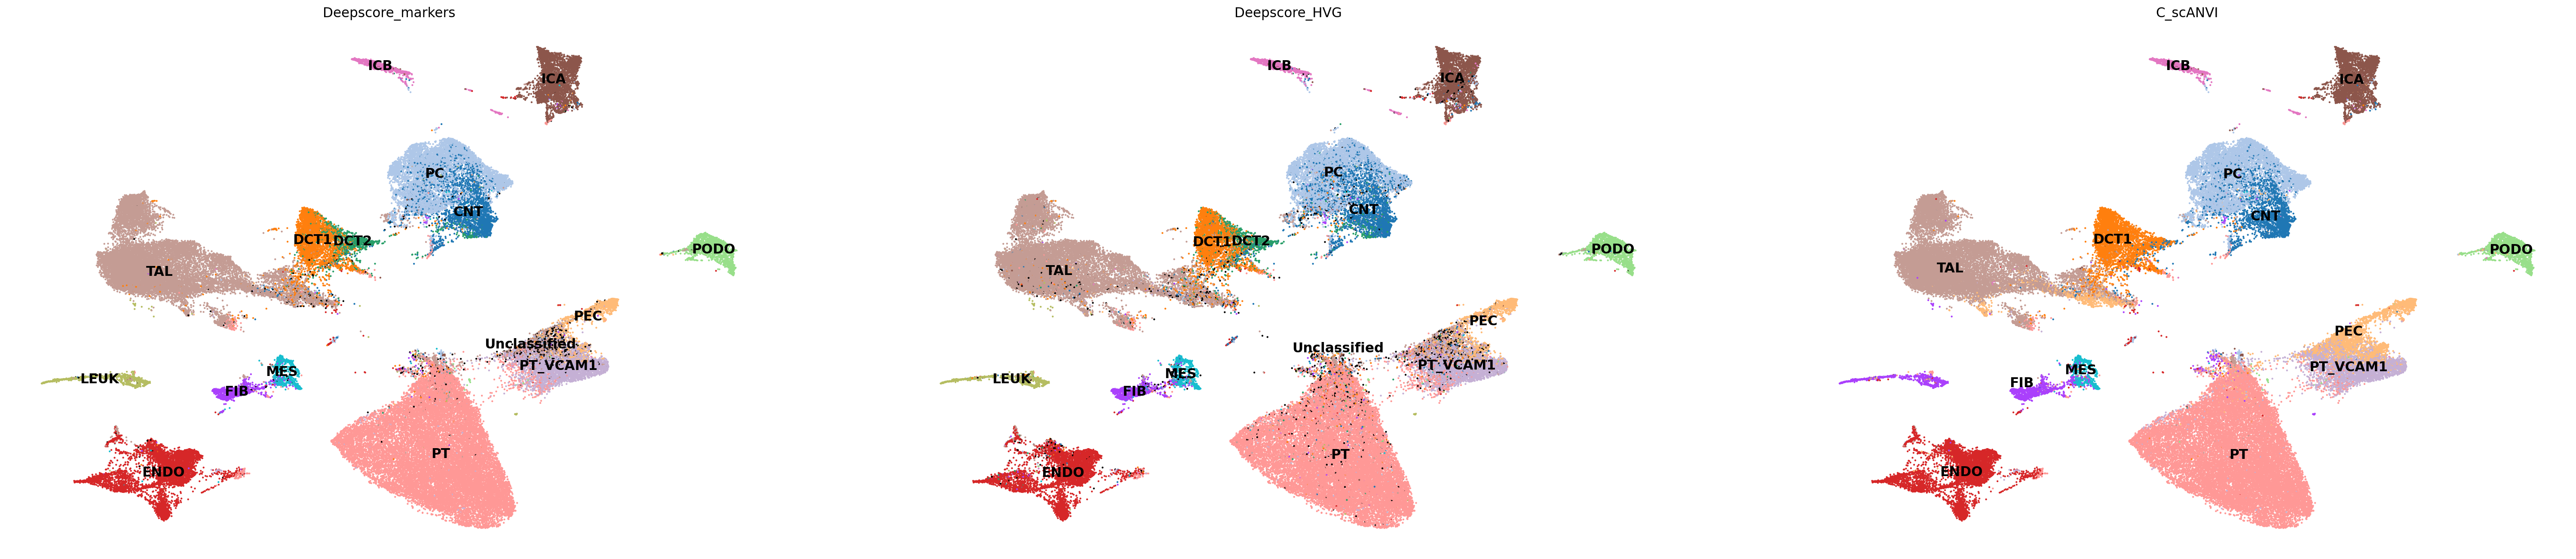

In [19]:
sc.pl.umap(adata, color = ['Deepscore_markers','Deepscore_HVG','C_scANVI'], frameon=False, legend_loc='on data', size = 15, palette = palette)

In [20]:
sc.tl.leiden(adata, resolution=0.5)

In [21]:
sc.settings.set_figure_params(figsize=('20', '10'), color_map='gist_earth')

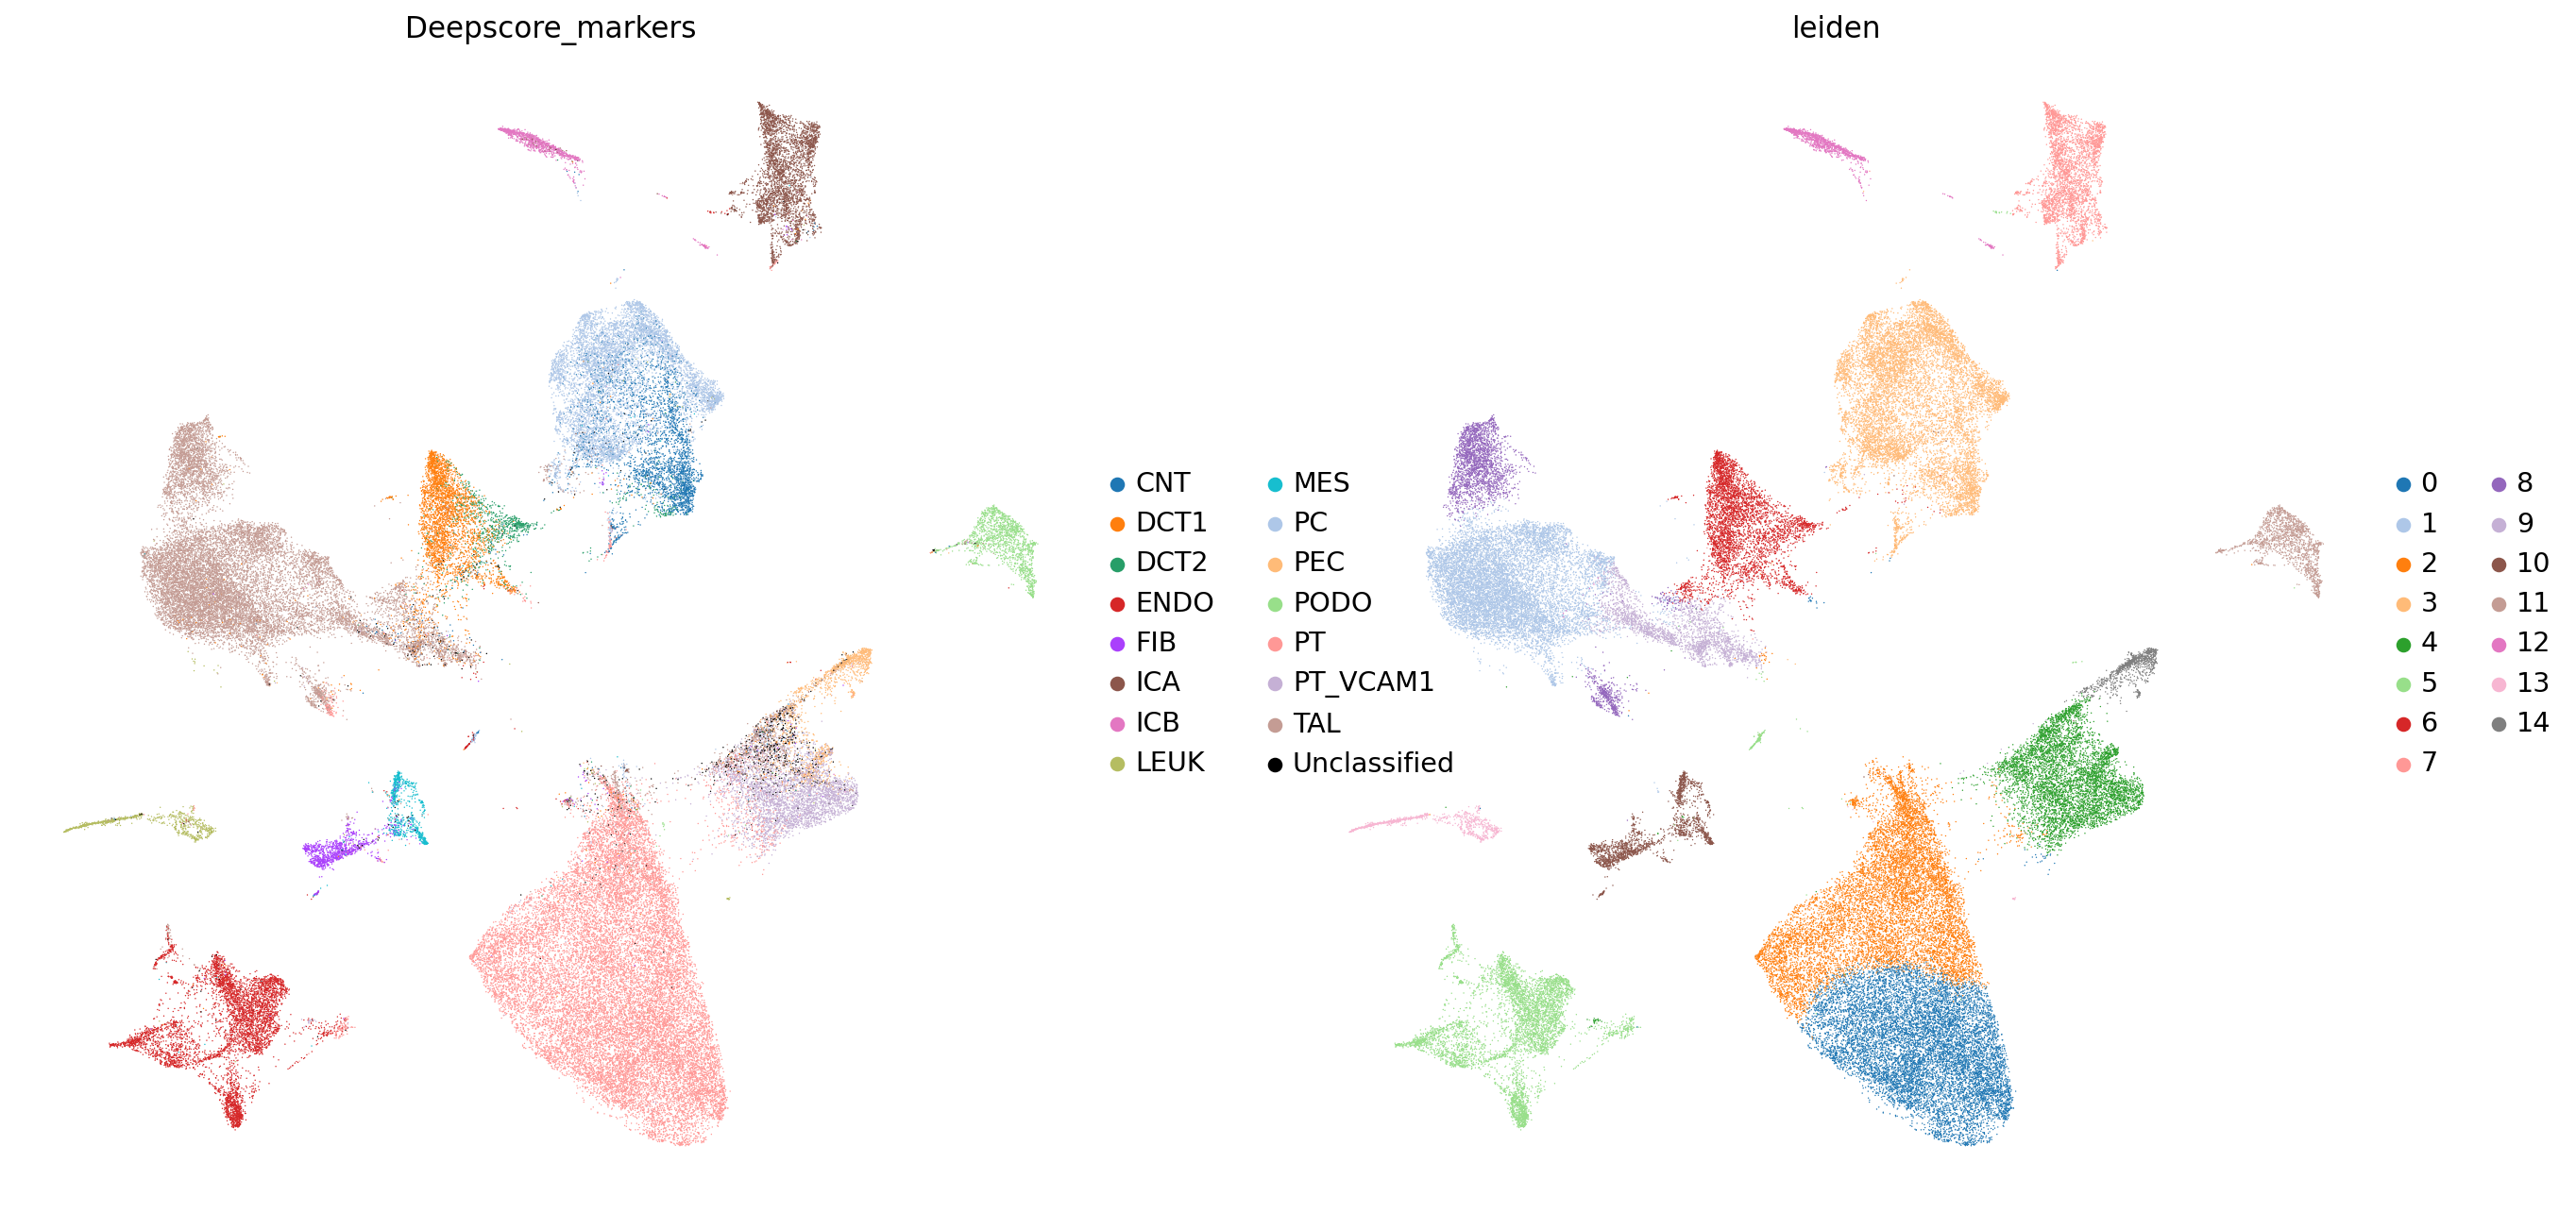

In [22]:
fig, ax = plt.subplots(1, 2, sharey=True)
sc.pl.umap(adata, color=["Deepscore_markers"], ax = ax[0], frameon=False, show=False, palette = palette)
sc.pl.umap(adata, color=["leiden"], ax = ax[1], frameon=False, palette = sns.color_palette("tab20",len(adata.obs['leiden'].unique())))


# APPLY 2nd STAGE QC Treshold

In [ ]:
adata_imm = adata[adata.obs['leiden'].isin(['13'])]
adata_non_im = adata[~adata.obs['leiden'].isin(['13'])]

del adata

print('Pre FILTERING, Immune, Non Immune Comparments:',adata_imm.shape,adata_non_im.shape )

# # SET AND APPLY THRESHOLDS to NON IMMUNE COMPARTMENT

mt_threshold = 70
nF_lower_threshold = 500

adata_non_im = adata_non_im[adata_non_im.obs['pct_counts_mt']<mt_threshold]

adata_non_im = adata_non_im[adata_non_im.obs['n_genes_by_counts']>nF_lower_threshold]

adata_non_im.write('objects/2ndQC_non_im.h5ad', compression='gzip')

In [ ]:
# # SET AND APPLY THRESHOLDS to IMMUNE COMPARTMENT

mt_threshold = 10
nF_lower_threshold = 200

adata_imm = adata_imm[adata_imm.obs['pct_counts_mt']<mt_threshold]

adata_imm = adata_imm[adata_imm.obs['n_genes_by_counts']>nF_lower_threshold]
adata_imm.write('objects/2ndQC_im.h5ad', compression='gzip')

In [ ]:
# print('Post FILTERING, Immune, Non Immune COmparments:',adata_imm.shape,adata_non_im.shape )
adata = sc.read('objects/2ndQC_im.h5ad').concatenate(sc.read('objects/2ndQC_non_im.h5ad'), join = 'outer')
print(adata)

AnnData object with n_obs × n_vars = 62865 × 35103
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore', 'Deepscore_markers', 'Deepscore_HVG', 'C_scANVI', 'leiden', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_pca_1stQC', 'X_pca_harmonized', 'X_pca_harmonized_1stQC', 'X_umap', 'X_umap_1stQC', 'X_umap_raw', 'X_umap_raw_1stQC'
    layers: 'counts'


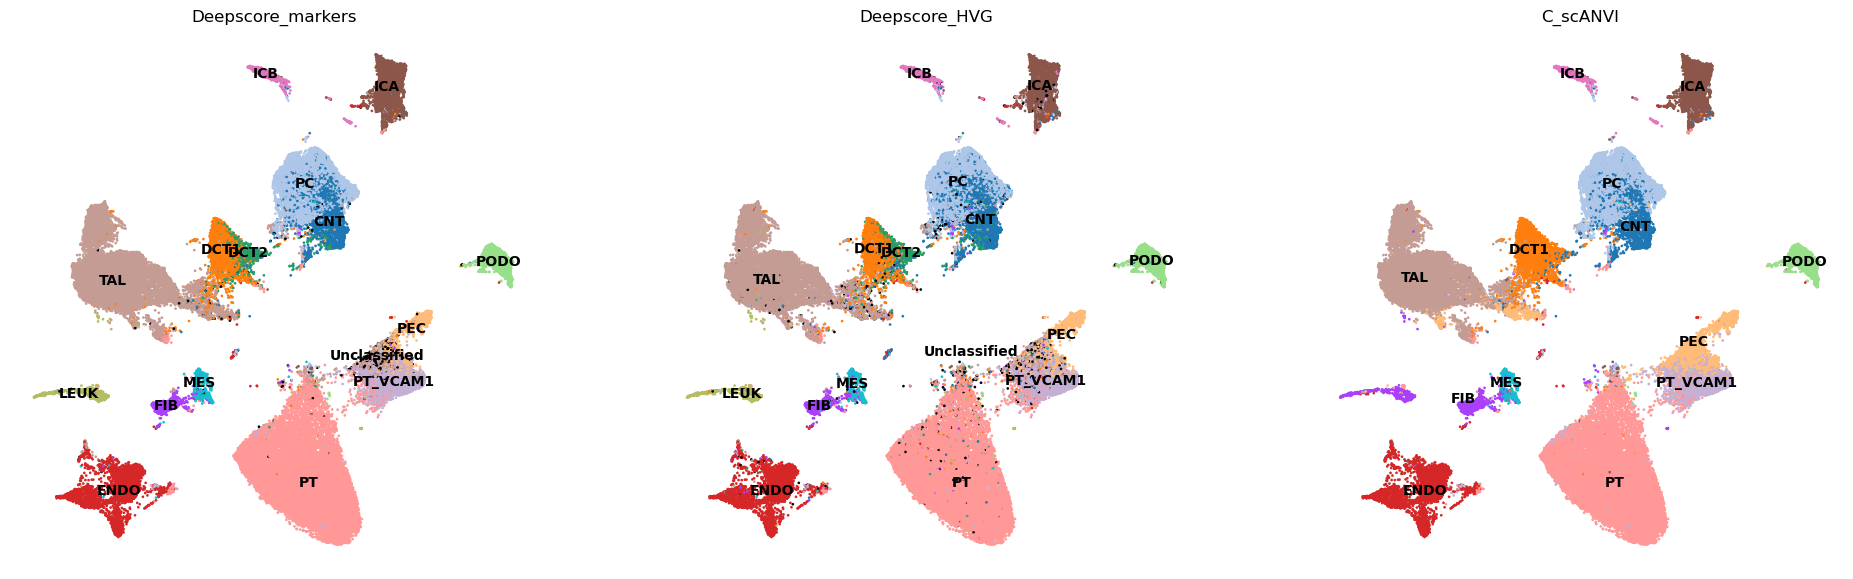

In [15]:
sc.pl.umap(adata, color = ['Deepscore_markers','Deepscore_HVG','C_scANVI'], frameon=False, legend_loc='on data', size = 15, palette = palette)

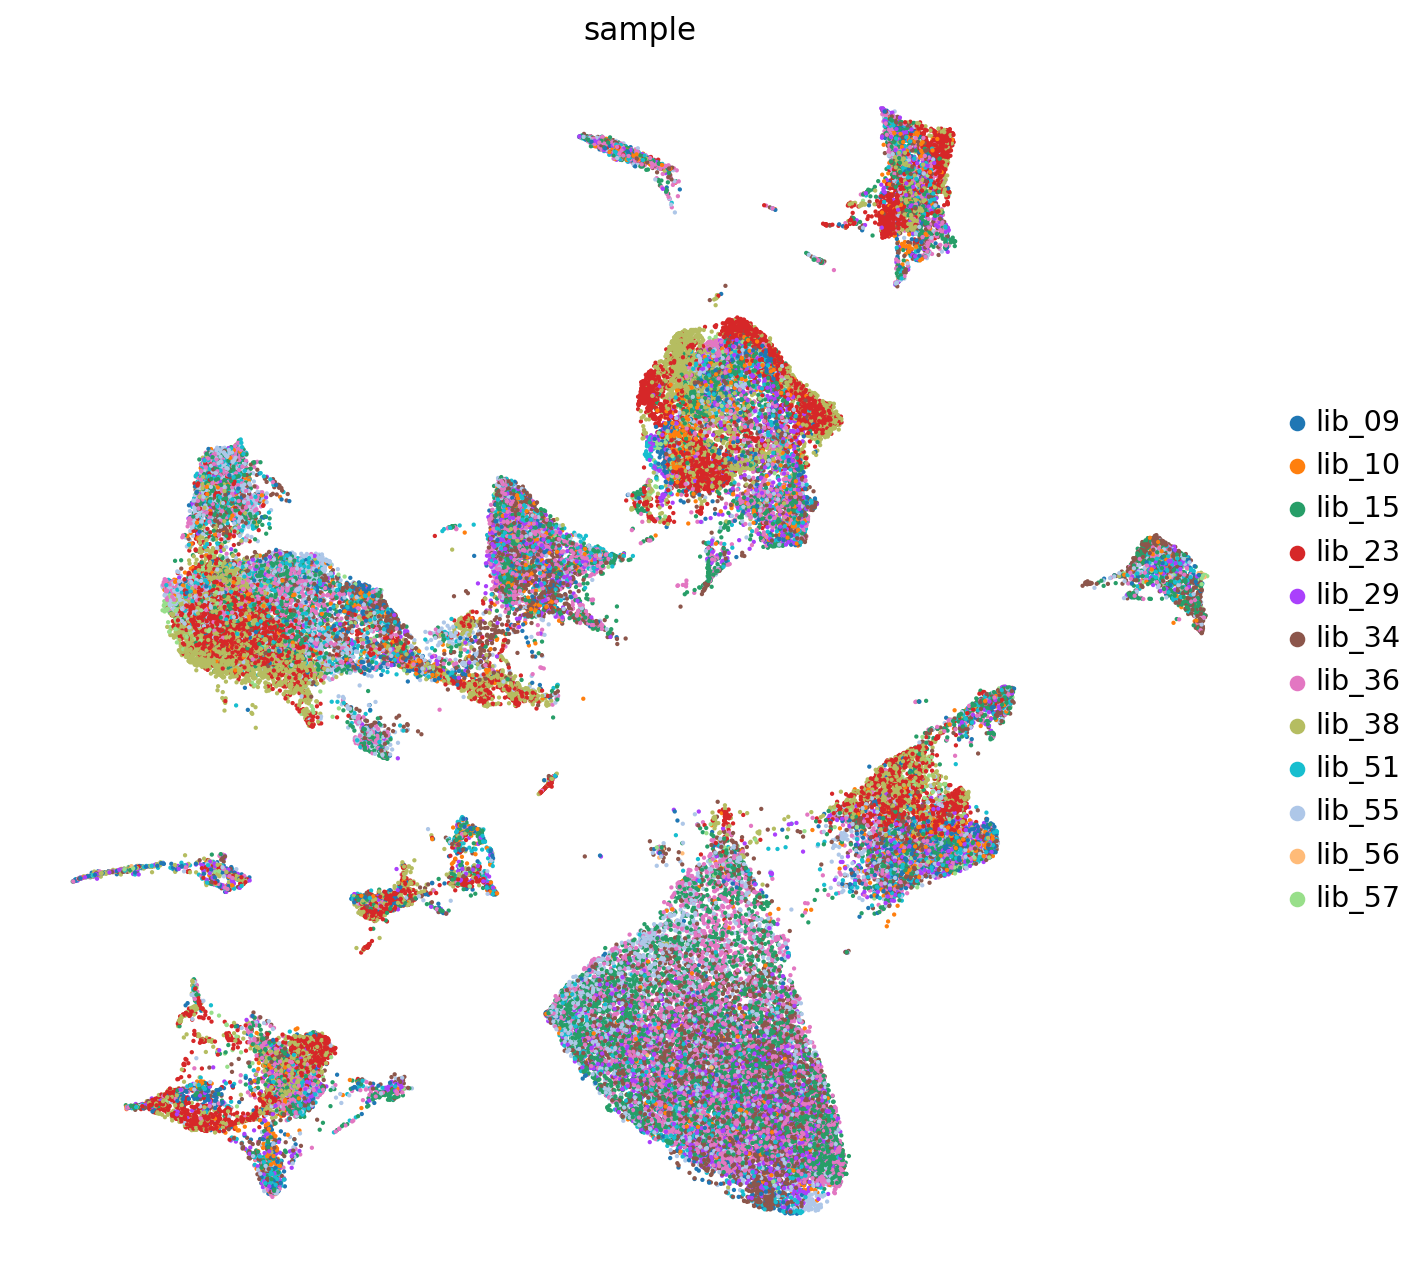

In [38]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')
sc.pl.umap(adata, color = ['sample'], frameon=False, size = 15)

CNT  DCT1  DCT2  ENDO  FIB   ICA  ICB  LEUK  MES    PC   PEC  \
CNT           2410    35    74    12    0    30    3     6    3   690     5   
DCT1            14  2757   104     3    3     5    0     3    2    23     0   
DCT2            84   217   676    14    0     4    1     2    1    21     3   
ENDO             2     5     0  4446    6    10    1     1    8    18     2   
FIB              3     4     1    31  800     2    0     0   40     8     2   
ICA              2     4     0     3    2  3174    3     0    1     6     2   
ICB              3     1     1     0    1    27  979     0    0     0     1   
LEUK             0     2     1     5    4     3    2   771    3     6     2   
MES              2     2     0     8   68     1    0     0  590     3     2   
PC             220    20     4    14    5    50    6     2    1  5775     6   
PEC              3    11     0    14    1     0    1     0    0    16  1160   
PODO             1     1     0     0    1     1    0     0    1     0     1   
PT               4    23     5    18    4    16    4     3    0    19    17   
PT_VCAM1         6    10     1     6    0     1    0     0    0    14    73   
TAL             22   176     5    30    5    43    0     2    2   124    54   
Unclassified    22    52    16    34   15    56    6     2    6   116    42   

              PODO     PT  PT_VCAM1    TAL  Unclassified  
CNT              3     49        22     90            37  
DCT1             0     85        19     82            20  
DCT2             4     28        11     36            13  
ENDO             0     39        12     21             9  
FIB              1     24         1     27             6  
ICA              2      8         4     16             4  
ICB              0      7         4      2             4  
LEUK             1     21         4     12             6  
MES              1     13         4      2             4  
PC               1     89        19     60            19  
PEC              0      8       181     96           125  
PODO          1357      4         2      5             1  
PT               5  16045       270    111            29  
PT_VCAM1         1    142      2421    134            56  
TAL              6    120        60  13262           152  
Unclassified     1    149       117    299           111

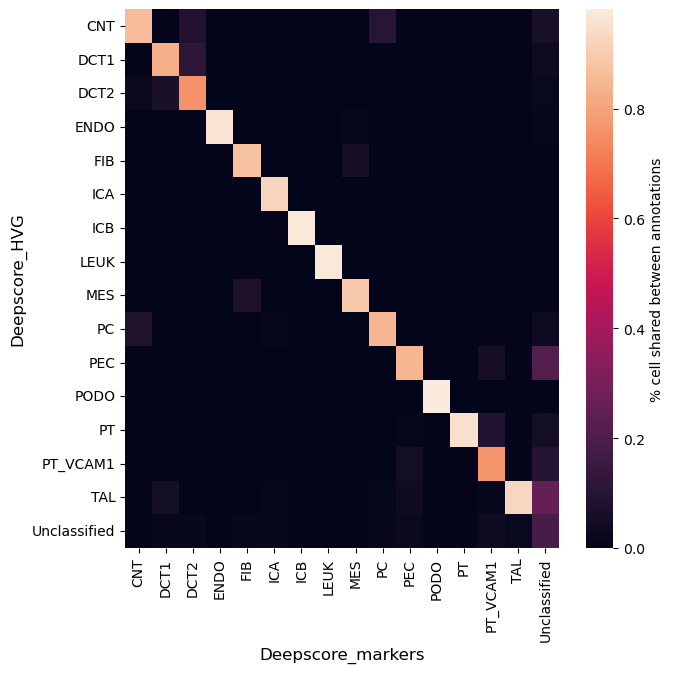

In [16]:
comparison_heatmap(adata, key1 = 'Deepscore_markers', key2='Deepscore_HVG')

In [50]:
adata.write('objects/2ndQC.h5ad', compression='gzip')